# Model Training and Evaluation
### 1. Load Engineered Dataset

In [2]:
import numpy as np
import pandas as pd
engineered_df = pd.read_pickle('../data/engineered_df.pkl')
engineered_df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,...,isOriginZeroed,amountToOldBalanceRatio,isAmountCloseToBalance,errorBalanceOrig,errorBalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,destAccountType_M
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,...,0,0.057834,0,0,1,0,0,1,0,1
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,...,0,0.087735,0,0,1,0,0,1,0,1
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,...,1,1.000000,1,0,1,0,0,0,1,0
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,...,1,1.000000,1,0,1,1,0,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,...,0,0.280795,0,0,1,0,0,1,0,1


In [3]:
engineered_df.columns

Index(['step', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'C_to_C', 'logAmount', 'oldbalanceDiff',
       'newbalanceDiff', 'balanceChangeOrig', 'balanceChangeDest',
       'isOriginZeroed', 'amountToOldBalanceRatio', 'isAmountCloseToBalance',
       'errorBalanceOrig', 'errorBalanceDest', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER', 'destAccountType_M'],
      dtype='object')

In [4]:
engineered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 26 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   step                     int64  
 1   amount                   float64
 2   nameOrig                 object 
 3   oldbalanceOrg            float64
 4   newbalanceOrig           float64
 5   nameDest                 object 
 6   oldbalanceDest           float64
 7   newbalanceDest           float64
 8   isFraud                  int64  
 9   isFlaggedFraud           int64  
 10  C_to_C                   int64  
 11  logAmount                float64
 12  oldbalanceDiff           float64
 13  newbalanceDiff           float64
 14  balanceChangeOrig        float64
 15  balanceChangeDest        float64
 16  isOriginZeroed           int64  
 17  amountToOldBalanceRatio  float64
 18  isAmountCloseToBalance   int64  
 19  errorBalanceOrig         int64  
 20  errorBalanceDest         int64  
 21  type_CAS

### 2. Data Preparation
Now let's prepare the data for modeling and train several machine learning models to detect fraud. Keeping in mind that `isFraud=1` only accounts for 0.13% (8,213 records) of the dataset...

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.pipeline import Pipeline as ImbPipeline

In [6]:
# Remove unnecessary columns
# Remove also step and balanceChangeDest - low feature importance from best model in previous run
model_df = engineered_df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud', 'step', 'balanceChangeDest'], axis=1)

# Remove any remaining non-numeric columns
model_df = model_df.select_dtypes(include=[np.number])

In [7]:
# Set difference to find dropped columns
dropped_columns = set(engineered_df.columns) - set(model_df.columns)

# Print the result as a sorted list
print("Dropped columns:")
print(sorted(dropped_columns))

Dropped columns:
['balanceChangeDest', 'isFlaggedFraud', 'nameDest', 'nameOrig', 'step']


To train machine learning models for fraud detection, we first split the dataset into training and testing sets using a stratified split, ensuring that the extremely low fraud rate (only ~0.13%, or 8,213 records) is preserved in both sets.
This mimics a realistic production scenario, where fraud is rare and must still be detected accurately.

After the split, we applied random and partial undersampling only to the training set to balance the number of fraudulent and non-fraudulent transactions. This helps the model learn to detect fraud more efficiently while keeping the test set imbalanced to allow for an honest evaluation under real-world conditions.

In [8]:
# Split from imbalanced data
X = model_df.drop('isFraud', axis=1)
y = model_df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Resample train set
train_df = pd.concat([X_train, y_train], axis=1)

# Separate classes
majority = train_df[train_df.isFraud == 0]
minority = train_df[train_df.isFraud == 1]

# Partial downsampling majority class
train_df_majority = resample(majority, replace=False, n_samples=2*len(minority), random_state=42)

# Recombine balanced train set
balanced_train_df = pd.concat([train_df_majority, minority])
X_train = balanced_train_df.drop('isFraud', axis=1)
y_train = balanced_train_df['isFraud']

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Fraud cases in training set: {sum(y_train)}, ({sum(y_train)/len(y_train)*100:.2f}%)")
print(f"Fraud cases in test set: {sum(y_test)}, ({sum(y_test)/len(y_test)*100:.2f}%)")

Training set shape: (19710, 20)
Test set shape: (1272524, 20)
Fraud cases in training set: 6570, (33.33%)
Fraud cases in test set: 1643, (0.13%)


In [9]:
X_train.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,C_to_C,logAmount,oldbalanceDiff,newbalanceDiff,balanceChangeOrig,isOriginZeroed,amountToOldBalanceRatio,isAmountCloseToBalance,errorBalanceOrig,errorBalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,destAccountType_M
5399229,417.94,50010.08,49592.14,0.00,0.00,0,6.037728,50010.08,49592.14,-417.94,0,8.357115e-03,0,0,1,0,0,1,0,1
4912531,266283.81,0.00,0.00,567485.49,923901.76,1,12.492322,-567485.49,-923901.76,0.00,0,2.662838e+15,0,1,1,1,0,0,0,0
4630179,14318.39,109017.82,94699.44,0.00,0.00,0,9.569370,109017.82,94699.44,-14318.38,0,1.313399e-01,0,0,1,0,0,1,0,1
4627520,575203.60,324943.00,0.00,902249.74,1477453.34,1,13.262481,-577306.74,-1477453.34,-324943.00,1,1.770168e+00,0,1,0,1,0,0,0,0
1012549,5366.47,21834.00,16467.53,0.00,0.00,0,8.588112,21834.00,16467.53,-5366.47,0,2.457850e-01,0,0,1,0,0,1,0,1


In [10]:
X_test.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,C_to_C,logAmount,oldbalanceDiff,newbalanceDiff,balanceChangeOrig,isOriginZeroed,amountToOldBalanceRatio,isAmountCloseToBalance,errorBalanceOrig,errorBalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,destAccountType_M
4051353,890577.21,218.00,0.00,0.00,890577.21,1,13.699626,218.00,-890577.21,-218.00,1,4.085217e+03,0,1,0,0,0,0,1,0
5746321,97734.24,2096258.84,2193993.08,320136.00,222401.76,1,11.490017,1776122.84,1971591.32,97734.24,0,4.662317e-02,0,1,1,0,0,0,0,0
6361797,5907.41,315.00,0.00,0.00,0.00,0,8.684132,315.00,0.00,-315.00,1,1.875368e+01,0,1,1,0,0,1,0,1
2247309,187696.30,11057.00,0.00,1798095.21,1985791.51,1,12.142586,-1787038.21,-1985791.51,-11057.00,1,1.697534e+01,0,1,0,1,0,0,0,0
4692207,82646.52,0.00,0.00,1047805.87,1130452.39,1,11.322340,-1047805.87,-1130452.39,0.00,0,8.264652e+14,0,1,0,1,0,0,0,0


### 3. Create Pipeline and Evaluate Models
**StandardScaler** to scale features down to zero mean and unit variance, important for models sensitive to feature scales i.e. SVM, LogReg, KNN.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [12]:
# Wrap models in pipeline with scaler
pipelines = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    ]),
    'RandomForestClassifier': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ]),
    'GradientBoostingClassifier': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ]),
    'XGBClassifier': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=10))
    ])
}

In [13]:
print(pipelines.keys())

dict_keys(['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier', 'XGBClassifier'])


In [14]:
# Helper function to fit pipelines and evaluate model performances
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name=None, save_transformed=True):
    # Fit model
    model.fit(X_train, y_train)

    # Auto-detect model name
    if model_name is None:
        if hasattr(model, 'named_steps'):
            model_name = type(model.named_steps['clf']).__name__
        else:
            model_name = type(model).__name__

    # Transform X_train and X_test if pipeline
    if hasattr(model, 'named_steps') and 'scaler' in model.named_steps:
        scaler = model.named_steps['scaler']
        X_train_transformed = pd.DataFrame(
            scaler.transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        X_test_transformed = pd.DataFrame(
            scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )

    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    # Report
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("-" * 50)

    return {
        'model': model,
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_proba': y_proba,
        'y_true': y_test,
        'X_train_transformed': X_train_transformed,
        'X_test_transformed': X_test_transformed
    }


In [15]:
# Train and evaluate model
results = []

for name, pipeline in pipelines.items():
    try:
        result = evaluate_model(pipeline, X_train, y_train, X_test, y_test)
        results.append(result)
    except Exception as e:
        print(f"Error in model {name}: {e}")

Model: LogisticRegression
Accuracy: 0.9968
Precision: 0.2864
Recall: 0.9976
F1 score: 0.4450
ROC AUC: 0.9994
Confusion Matrix:
[[1266797    4084]
 [      4    1639]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.29      1.00      0.45      1643

    accuracy                           1.00   1272524
   macro avg       0.64      1.00      0.72   1272524
weighted avg       1.00      1.00      1.00   1272524

--------------------------------------------------
Model: RandomForestClassifier
Accuracy: 0.9998
Precision: 0.8520
Recall: 0.9988
F1 score: 0.9196
ROC AUC: 0.9994
Confusion Matrix:
[[1270596     285]
 [      2    1641]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.85      1.00      0.92      1643

    accuracy                           1.00   1272524
   macro avg       0

In [16]:
# Convert list of results dicts into DataFrame
results_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Accuracy': r['accuracy'],
    'Precision': r['precision'],
    'Recall': r['recall'],
    'F1 Score': r['f1'],
    'ROC AUC': r['roc_auc']
} for r in results])

# Sort by F1 Score or any other metric
results_df = results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

# Display results
print("\n📊 Model Performance Summary:")
display(results_df)


📊 Model Performance Summary:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,RandomForestClassifier,0.999774,0.852025,0.998783,0.919585,0.999355
1,XGBClassifier,0.999574,0.752407,0.998783,0.858264,0.999631
2,GradientBoostingClassifier,0.999062,0.579449,0.998783,0.733408,0.998411
3,LogisticRegression,0.996787,0.286388,0.997565,0.445018,0.999399


### 4. Plot Model Performances

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

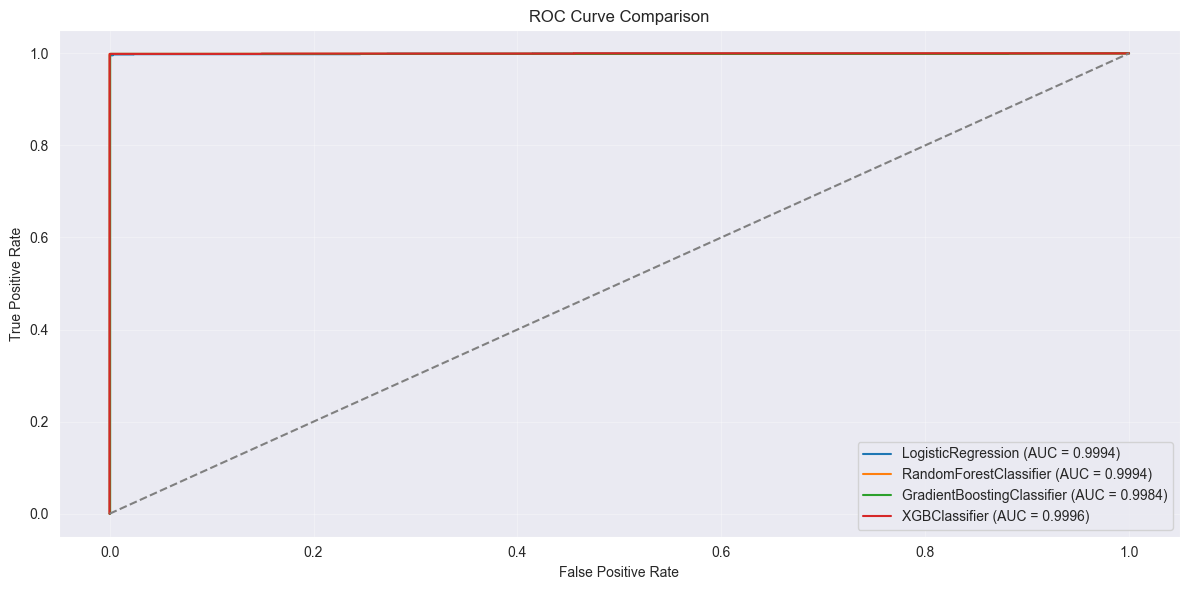

In [18]:
# Plot ROC Curve for all models
plt.figure(figsize=(12, 6))
for r in results:
    fpr, tpr, _ = roc_curve(r['y_true'], r['y_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{r['model_name']} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

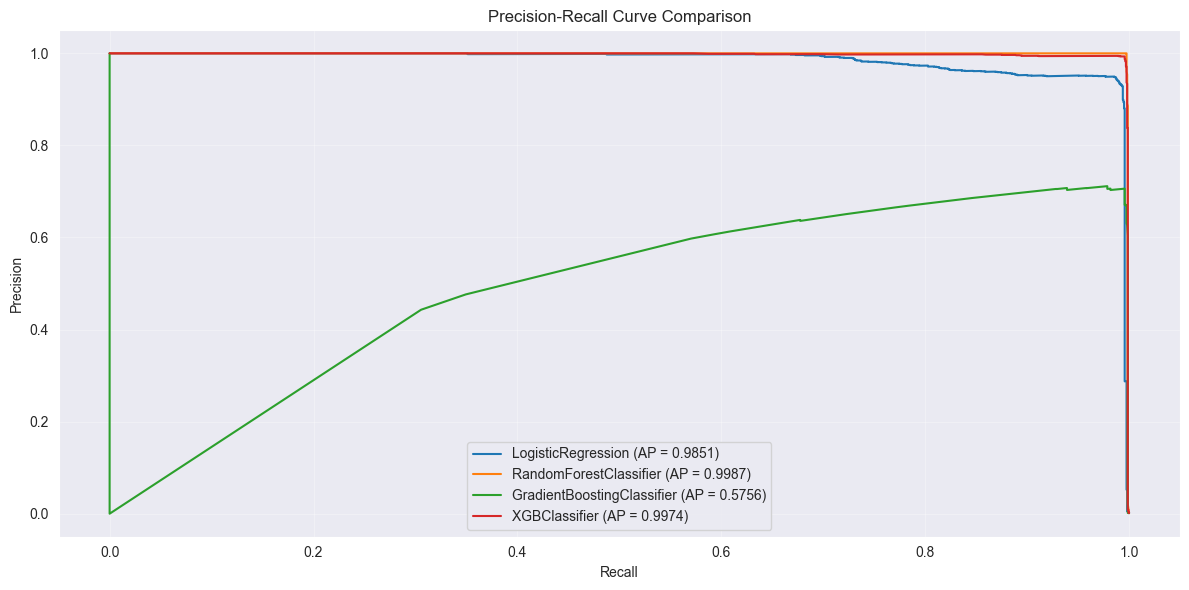

In [19]:
# Plot Precision-Recall curve
plt.figure(figsize=(12, 6))

for r in results:
    precision, recall, _ = precision_recall_curve(r['y_true'], r['y_proba'])
    ap = average_precision_score(r['y_true'], r['y_proba'])
    plt.plot(recall, precision, label=f"{r['model_name']} (AP = {ap:.4f})")

plt.title("Precision-Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Takeaway from Model Evaluation via Precision-Recall Curve
The Precision-Recall (PR) curve offers a clearer picture of model performance in the context of highly imbalanced fraud detection, where recall (how many real frauds the model caught) and precision (how many predicted frauds are actually fraud) are critical.

From the PR curve:
- RandomForestClassifier stands out with near-perfect area under the PR curve (AP = 0.9987), maintaining both high precision and recall across a wide range of thresholds. It is the most balanced and reliable model for deployment.
- XGBClassifier also performs extremely well (AP = 0.9977), closely following Random Forest and may be preferred in scenarios where boosting methods have operational advantages.
- LogisticRegression, despite its simplicity, performs admirably (AP = 0.9830) and could be a strong fallback when model interpretability or deployment simplicity is prioritized.
- GradientBoostingClassifier significantly underperforms (AP = 0.6365), suggesting poor handling of the class imbalance or insufficient model tuning.

These results emphasize the importance of evaluating models not just by accuracy or AUC, but by how well they balance precision and recall under real-world class distributions. Going forward, Random Forest or XGBoost would be strong candidates for production deployment, with additional tuning and threshold optimization to further refine performance.

### 5. Hyperparameter Tuning for Best Model

In [20]:
best_model_name = results_df.iloc[0]['Model']
print(f"Tuning hyperparameters for {best_model_name}")

Tuning hyperparameters for RandomForestClassifier


In [21]:
from sklearn.model_selection import GridSearchCV

# Define param search based on best model
if best_model_name == 'LogisticRegression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': ['balanced', None]
    }
    base_model = LogisticRegression(max_iter=1000, random_state=42)

elif best_model_name == 'RandomForestClassifier':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', None]
    }
    base_model = RandomForestClassifier(random_state=42)

elif best_model_name == 'GradientBoostingClassifier':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 0.9, 1.0]
    }
    base_model = GradientBoostingClassifier(random_state=42)

elif best_model_name == 'XGBClassifier':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'scale_pos_weight': [1, 5, 10]
    }
    base_model = XGBClassifier(random_state=42)

# Grid search with cross validation
grid_search = GridSearchCV(estimator=base_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1',
                           n_jobs=-1,
                           verbose=2)

# Fit grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END class_weight=balanced, max_depth=None, min_sa

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1', verbose=2)

In [22]:
# Evaluate tuned model
best_model = grid_search.best_estimator_
print("Best model object:")
print(best_model)

# Print best parameters
print("\nBest parameters:")
print(grid_search.best_params_)

Best model object:
RandomForestClassifier(class_weight='balanced', min_samples_split=5,
                       n_estimators=200, random_state=42)

Best parameters:
{'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [23]:
# Simple evaluation function
def evaluate_basic(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # Fallback if predict_proba is not available
        y_proba = y_pred

    cm = confusion_matrix(y_test, y_pred)

    return {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'confusion_matrix': cm
    }

In [24]:
tuned_result = evaluate_basic(best_model, X_train, y_train, X_test, y_test)

# Create DataFrame from result
tuned_result_df = pd.DataFrame([{
    'Model': best_model_name,
    'Accuracy': tuned_result['accuracy'],
    'Precision': tuned_result['precision'],
    'Recall': tuned_result['recall'],
    'F1 Score': tuned_result['f1'],
    'ROC AUC': tuned_result['roc_auc']
}])

tuned_result_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,RandomForestClassifier,0.999772,0.8507,0.998783,0.918813,0.999334


In [25]:
# Get confusion matrix for untuned RandomForestClassifier
cm_before_matrix = next(r['confusion_matrix'] for r in results if r['model_name'] == 'RandomForestClassifier')

cm_before_matrix = None
for r in results:
    if r['model_name'] == 'RandomForestClassifier':
        cm_before_matrix = r['confusion_matrix']
        break

if cm_before_matrix is None:
    print("RandomForestClassifier not found in results.")

In [26]:
cm_before_matrix

array([[1270596,     285],
       [      2,    1641]])

In [27]:
cm_after_matrix = tuned_result['confusion_matrix']
cm_before_matrix

array([[1270596,     285],
       [      2,    1641]])

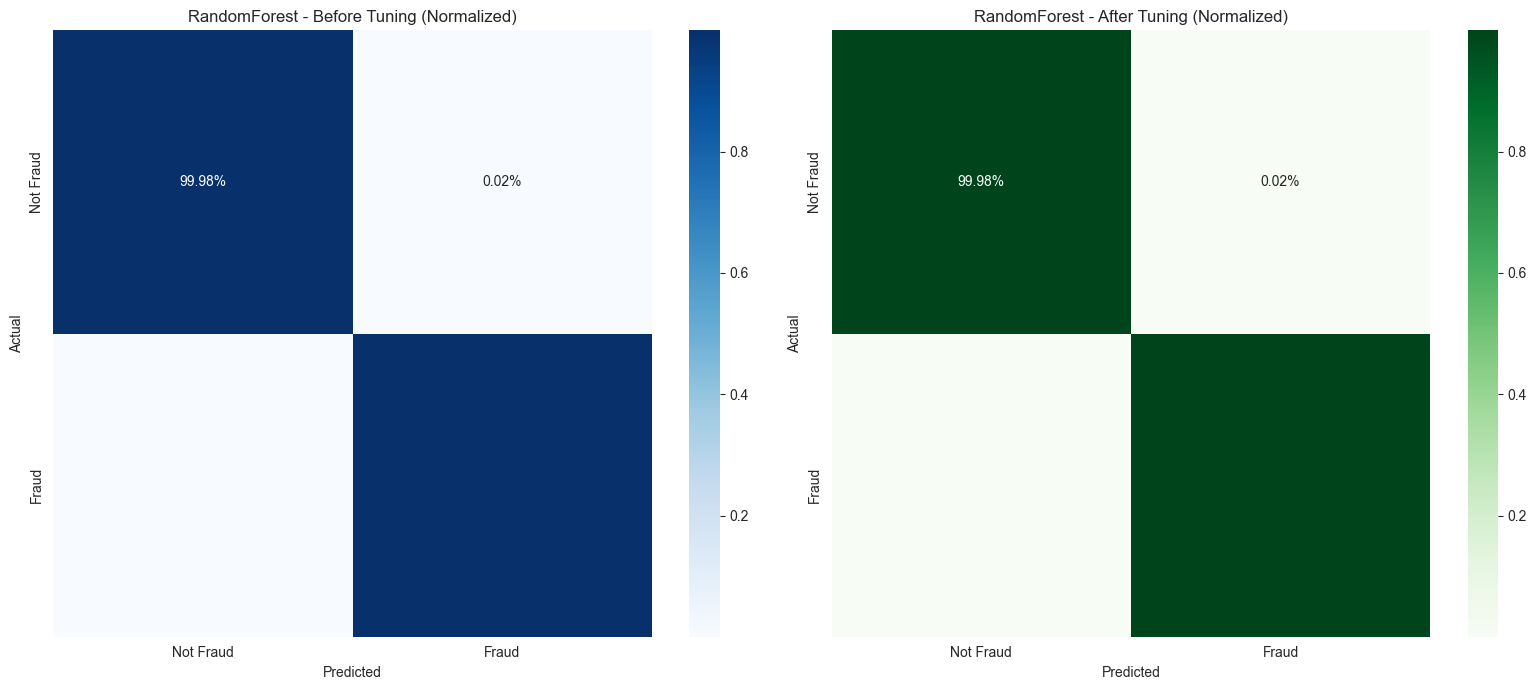

In [28]:
# Define class labels
labels = ['Not Fraud', 'Fraud']

# Convert to float and normalize by row (per class)
cm_before_norm = cm_before_matrix.astype("float") / cm_before_matrix.sum(axis=1)[:, np.newaxis]
cm_after_norm = cm_after_matrix.astype("float") / cm_after_matrix.sum(axis=1)[:, np.newaxis]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(cm_before_norm, annot=True, fmt=".2%", cmap="Blues",
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("RandomForest - Before Tuning (Normalized)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_after_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title("RandomForest - After Tuning (Normalized)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

### 6. Feature Importance
> Seems like both tuned and untuned rf model yield the same results. We will now extract feature importance from the best model.

In [29]:
# Feature importances
importances = best_model.feature_importances_

# Use column names from your training set
feature_names = X_train.columns

# Build DataFrame
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display
importances_df

,Feature,Importance
12,isAmountCloseToBalance,0.285571
13,errorBalanceOrig,0.157674
11,amountToOldBalanceRatio,0.130735
9,balanceChangeOrig,0.124490
10,isOriginZeroed,0.107243
2,newbalanceOrig,0.047690
1,oldbalanceOrg,0.028600
0,amount,0.020490
6,logAmount,0.016844
8,newbalanceDiff,0.016622


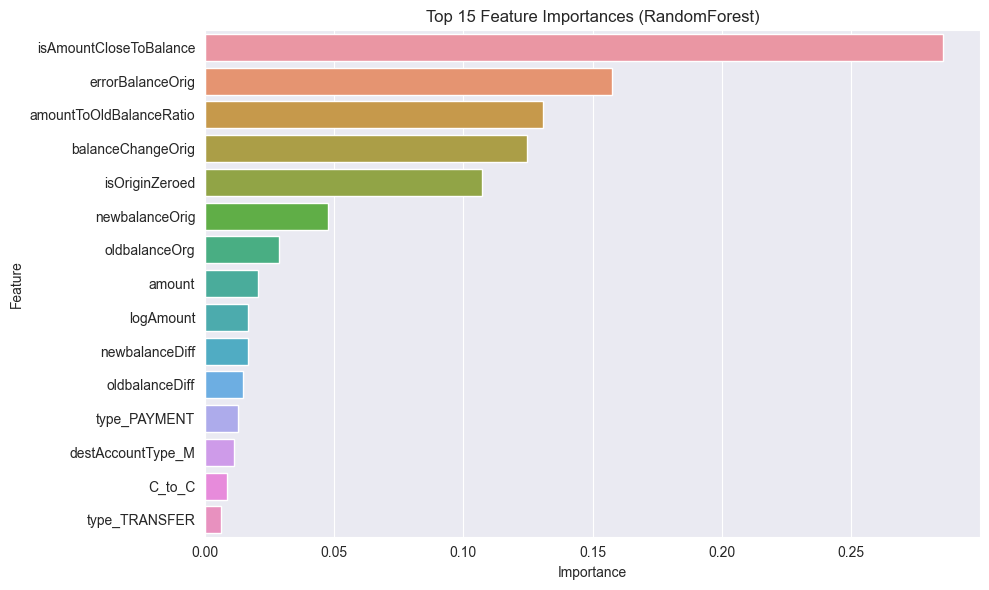

In [30]:
# Visualize feature importances - top 15
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(15))
plt.title('Top 15 Feature Importances (RandomForest)')
plt.tight_layout()
plt.show()

### Final Thought
In this notebook, we...
- Performed partial downsampling (2:1 non-fraud to fraud) on train data to mitigate class imbalance while preserving model generalizability.
- Tested models on realistic test data, retaining 0.13% fraud rate similar to the PaySim dataset.
- Drawn conclusion that RandomForestClassifier emerged as top-performing model in terms of F1 score.
- Extracted feature importance from best model, as anticipated, `isAmountCloseToBalance` dominates the feature importance chart. This is a strong fraud signal which aligned with our expectations drawn from EDA and feature engineering phase.

Overall, this experiment provides a solid baseline for production-level fraud detection, while also highlighting the importance of aligning training distribution with real-world class imbalance.

In [31]:
import os
from joblib import dump

model_dir = os.path.join(os.getcwd(), "..", "models")
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, f"best_{best_model_name}.joblib")

dump(best_model, model_path)
print(f"Saved fine-tuned model to {model_path}")

Saved fine-tuned model to /Users/jenniet./Desktop/IMDA/Capstone proj/aml_kafka_proj/src/../models/best_RandomForestClassifier.joblib
